# LSTM with attention in Encoder-Decoder 

### implementing first paper to use attention with rnn Neural Machine Translation by Jointly Learning to Align and Translate Bahdanau , Bengio

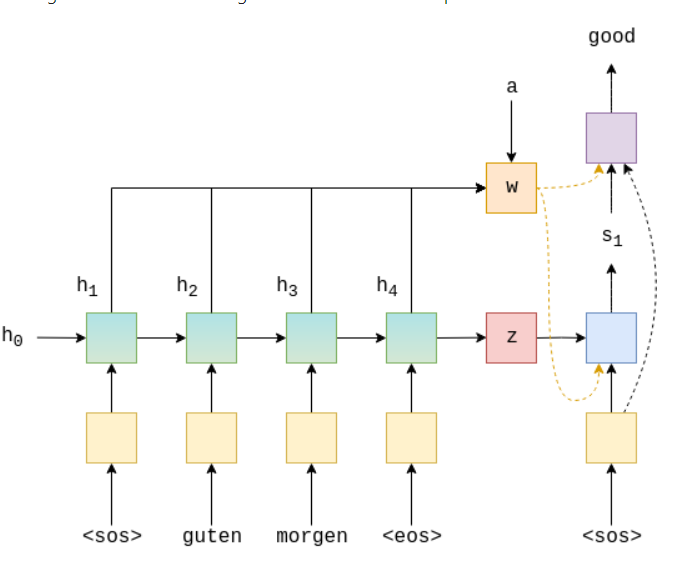

#### Encoder
- Encoder is trained as biLSTM. 
- Takes in src text ( german) in forward pass 
- model returns output( concatanated bidirectional hidden for each timestep) and final layer final timestep bidirectional concatanated hidden,cell states which serve as hidden,cell to initialize the decoder with.
- Final linear is added which brings the hidden, cell features from 2*hidden_dims back to hidden_dims to be able to use h,c to initialize hc of decoder.

#### attention layer
Takes the previous hidden state S t-1, all of the encoder hidden states H, and returns attention vector A for time t of size = encoder input seqlen

.
- This will take in the previous hidden state St-1 of the decoder [batch size, hid dim]
- all of the stacked forward and backward hidden states from the encoder H [ batch size,src len, hid dim * num directions] 
- for time t = 0, s t-1 = s0 = hidden,cell state from encoder used to initialize hidden,cell of decoder
- The layer will output an attention vector A at time t, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1, where closer to 1 meaning at time t of decoding should attend to that word in the input seq of encoder.

- hidden state St-1 of the decoder [batch size, hid dim]. hidden states unlike outputs ( which are for entire seq), are only for one seq which is why seq len dimension is noth there.
- H which is basically output from encoder[ batch size,src len, hid dim * 2]
- INTUTITIVELY this layer takes what we have decoded so far s t-1 and all of what we have encoded H (output of encoder) to produce a vector Attention at time t, that represents which words in the source sentence ( output from encoder is hidden state for each sequence elemt and has seq len in its dimensions) we should pay the most attention at time t in order to correctly predict the next word to decode



## attention working

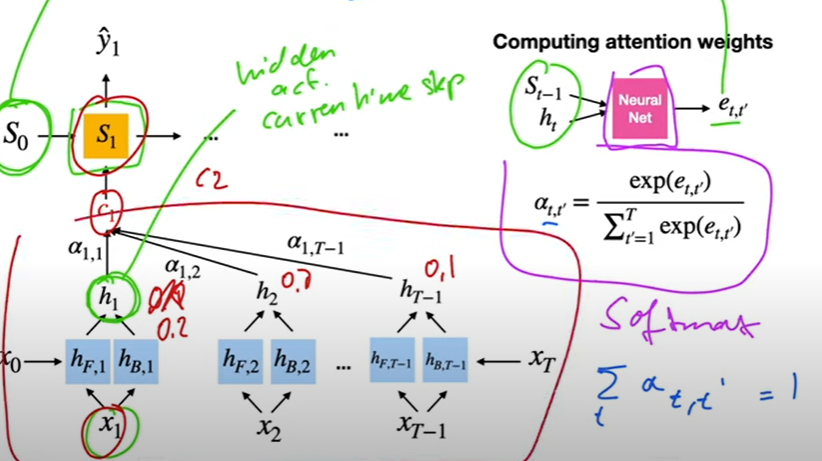


- attention requires two linear layers ( essentially two sets of weights W and v) to calculate energy scores for each element in the sequence length , which are then softmaxed to get them between 0-1

- first we pass S t-1 and H through a linear layer called self.attn. As our encoder hidden states are a sequence of T ( seq len) tensors [batch size, src len,  enc hid dim * 2], and our previous decoder hidden state is a single tensor [batch size, dec hid dim], the first thing we do is repeat the previous decoder hidden state T times [batch size, seqlen, dec hid dim]

- concat the two tensor over dim 2 and pass it as input to linear layer with outfeatures of the layer as dec hidden [batch size, src len, dec hid dim].
- Now pass through another linear layer that outputs as 1 feature [batch size, src len, 1]
- Next sqeeze out the 1 at the end to get [batch size, src len] as output
- this output [batch size, src len] is the energy scores for each element in seq len for each sameple in batch
- pass these through softmax to get normalized scores whcih are finally called attention


## decoder

- We then use this attention vector to create a weighted source vector Wt denoted by weighted, which is a weighted sum of the encoder hidden states H using At as weights

Wt = At.H

##### Then three inputs are sent to decoder LSTM - 

Concatanat Wt and input embedded yt as input
1) this Wt, 
2) the previous hidden,cell state ( S t-1), 
3) the input token yt ( sos for first, if teacher forcing then the target word, if inferencing then the previous predicted word from lstm)

##### inputs to the linear layer for prediction

Concatanate all below

1) embedded input word yt, 
2) wt, 
3) st ( single timestep output or hidden of lstm at time t)

#### Prediction token is Yt+1

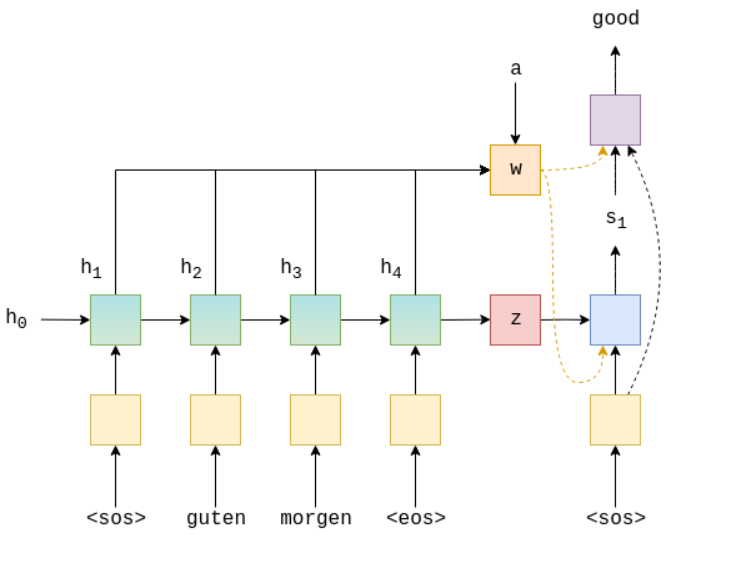






In [ ]:
import torch
print(torch.__version__) # 1.13.1+cu117

In [ ]:
from ANNhelper import set_all_seeds,log_setup,configuration, ANN,VAE, Net, custReshape, Trim, CNN1D, RNN_classification
from ANNhelper import BatchSamplerSimilarLength, hiddenBidirectional, hiddenUnidirectional, squeezeOnes
from ANNhelper import BidirectionextractHiddenfinal, UnidirectionextractHiddenfinal, permuteTensor, globalMaxpool, MultiNet
from ANNhelper import LSTMhc,UnidirectionextractHiddenCell,UnidirectionalextractOutput,Linearhc,Seq2Seq,RNNhc,unsqueezeOnes
from ANNhelper import concatTwotensors, concatThreetensors, UnidirectionextractHidden, decoder_cho, hcHiddenonlyBidirectional
from ANNhelper import hcBidirectional, BidirectionextractHCfinal, Bidirectionfullprocess, activationhc, Linearhchiddencell
from ANNhelper import decoder_attn, Attention
from datahelper import preProcess

from ANNdebug import CNNparamaterStats,FCNparameterStats, hook_prnt_activations, hook_prnt_activation_norms
from ANNdebug import hook_prnt_inputs, hook_prnt_weights_grad_stats, callback_prnt_allweights_stats
from ANNdebug import callback_prnt_allgrads_stats, callback_prnt_weights_stats
from ANNdebug import hook_prnt_inputs_stats, hook_prnt_activations_stats, hook_prnt_inputs_norms, hook_return_activations, hook_return_inputs
from ANNdebug import activation as hookactivations
from ANNdebug import inputs as hookinputs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import torchtext
import torchdata
import spacy

from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab, Vectors
from torch.utils.data import Sampler, Dataset
from torchtext.data.utils import get_tokenizer
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler, Dataset
from torchtext.data import get_tokenizer

import sys, psutil, os,copy

import time
import datetime
import random
import logging
logging.raiseExceptions = False
import logging.handlers
from packaging import version

import collections
import unicodedata
import unidecode
import string
import re

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, multilabel_confusion_matrix, confusion_matrix
from yellowbrick.regressor import PredictionError, ResidualsPlot


#New for importing data
import torchvision
import torchvision.transforms as T

In [ ]:
# for deterministic result with the lesson

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# download data

from torchtext.datasets import multi30k, Multi30k

# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset 
multi30k.MD5["test"] = "6d1ca1dba99e2c5dd54cae1226ff11c2551e6ce63527ebb072a1f70f72a5cd36"

data_train = Multi30k(split='train')
data_val = Multi30k(split='valid')
data_test = Multi30k(split='test')


In [ ]:
# create datapipes/iterables for train and valid

language_pair = ("de", "en")

train_data, valid_data = torchtext.datasets.Multi30k(split = ('train', 'valid'), language_pair=language_pair)

#print (type(train_data)) # <class 'torch.utils.data.datapipes.iter.grouping.ShardingFilterIterDataPipe'>

#print (len(list(train_data))) # 29001
#print (len(list(valid_data))) # 1015

for i in train_data:
    print (i, type(i), i[0])
    break
    
"""
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'Two young, White males are outside near many bushes.') 
<class 'tuple'> 
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
"""

# creating lists with just german and seperate list for just english sentences

justgermanls = []
justenglishls = []

for i in train_data:
    justgermanls.append(i[0])
    justenglishls.append(i[1])

print (len(justgermanls))#29001


############## creating reverse pairs

re_train_data, re_valid_data = torchtext.datasets.Multi30k(split = ('train', 'valid'), language_pair=("en","de"))


In [ ]:
# tokenizer to use

tokenizer_en = get_tokenizer('spacy', language="en_core_web_sm")
tokenizer_de = get_tokenizer('spacy', language="de_core_news_sm")

In [ ]:
# save and load vocab
#torch.save(vocabularyen, 'en_vocab_de_to_en')
#torch.save(vocabularyde, 'de_vocab_de_to_en')
vocabularyen = torch.load('en_vocab_de_to_en')
vocabularyde = torch.load('de_vocab_de_to_en')

vocabularyen.set_default_index(vocabularyen["<UNK>"])
vocabularyde.set_default_index(vocabularyde["<UNK>"])


padding_value_en = vocabularyen['<PAD>']
starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<PAD>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']

print (starting_val_de, starting_val_en)

In [ ]:

batch_size = 128
embed_dims =  256
hidden_dims = 512
num_layers =  1
dropout = 0.5
bidirectional = True

# configuring encoder network for german texts

######### Encoder is trained as biLSTM. Takes in src text ( german) in forward pass and model returns 
#output(hidden for each timestep) and final layer concatanated hidden,cell states for bidirectional which serve as hidden,
#cell to initialize the decoder with.

confde  = configuration()

embed_de = confde.embeddings(len(vocabularyde),embed_dims )
# BiLSTM
lstm_de = confde.lstm(embed_dims,hidden_dims,num_layers=num_layers,bidirectional=bidirectional, dropout = dropout)

drop_de =  confde.dropout(dropout)

# Bidirectionfullprocess()

#### see next cell for shape details with toy run###

linear_de = Linearhchiddencell(hidden_dims*2,hidden_dims )
## linear is added here which bring the feature from 2*hidden_dims back to hidden_dims to be able to use h,c to initialize
# hc of decoder.
tanh_de = activationhc(torch.nn.Tanh())
#This takes in the output of lstm and only processes the hc through act func and returns out, (h,c)

encoderlayers= {1:embed_de,2:drop_de, 3:lstm_de, 4:Bidirectionfullprocess(), 5:linear_de, 6:tanh_de }

confde.configureRNN(rnnlayers = encoderlayers, params ={"batch_size":batch_size,"pretrained_embeddings" : False} )


In [ ]:
encoderGerman = Net()
encoderGerman.vocabulary = vocabularyde
encoderGerman.tokenizer = tokenizer_de
#encoderGerman.train_dp,encoderGerman.test_dp =  train_data, valid_data

#encoderGerman.train_dp_list = list(encoderGerman.train_dp)
#encoderGerman.test_dp_list = list(encoderGerman.test_dp)

encoderGerman.configureNetwork(confobj = {'RNN':[confde]}, RNN = True, networktest = False)


In [ ]:
##### run just encoder as a model to understand flow and shapes #################

decoderEng = Net()
decoderEng.vocabulary = vocabularyen
decoderEng.tokenizer = tokenizer_en
def collate_batch_custom(batch):
    
    encoder_list, decoder_list = [], []
    for _encode, _decode in batch:
        tmp_tok = encoderGerman.tokenizer(_encode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        
        processed_text = torch.tensor(encoderGerman.vocabulary.lookup_indices(tmp_tok))
        encoder_list.append(processed_text)
        
        tmp_tok = decoderEng.tokenizer(_decode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        
        processed_text = torch.tensor(decoderEng.vocabulary.lookup_indices(tmp_tok))
        decoder_list.append(processed_text)
        

    return pad_sequence(encoder_list, batch_first=True,padding_value=padding_value_de), pad_sequence(decoder_list, batch_first=True,padding_value=padding_value_en)


encoderGerman.train_dp,encoderGerman.test_dp, encoderGerman.valid_dp  =  train_data, valid_data, valid_data

encoderGerman.train_dp_list = list(encoderGerman.train_dp)
encoderGerman.test_dp_list = list(encoderGerman.test_dp)
encoderGerman.valid_dp_list = list(encoderGerman.valid_dp)

print (encoderGerman.train_dp_list[0])

# make seq2seq loader and run network test- always use full batch in case of RNN as this is something hardocded in nets used
encoderGerman.makeLoadersAdv(batch_size=128,collate_fn= collate_batch_custom)
print (encoderGerman.net)


tmpx1,tmpx2 = next(iter(encoderGerman.train_loader))
print (tmpx1.shape) # [batchsize, seqlen] of src text [128, 23])

y = encoderGerman.net(tmpx1)

# output of BiLSTM: [ batch size,src len, hid dim * num directions] torch.Size([128, 20, 1024]) 
# hidden [n layers * num directions, batch size, hid dim] torch.Size([2, 128, 512]) 
#h_n = [batchs, hidden_dims*2] due to concatanations torch.Size([128, 1024])

print (y[0].shape, y[1][0].shape,y[1][1].shape ) 
# output of BiLSTM: [ batch size,src len, hid dim * num directions] torch.Size([128, 20, 1024]) 
#hidden after being passed through lnear which transforms from 2*hidden to hidden ( done as this is sent to decoder) and tanh 
# [batch size, hid dim] torch.Size([128, 512])
         

############################################################################################################

In [ ]:
# configuring decoder netowrk for english translation

attention = Attention(hidden_dims, hidden_dims)

decoderEng = Net()
decoderEng.vocabulary = vocabularyen
decoderEng.tokenizer = tokenizer_en
decoderEng.net = decoder_attn(len(vocabularyen),embed_dims, hidden_dims, hidden_dims, num_layers, dropout,attention)


In [ ]:

seq2seq  = Net()
seq2seq.setupCuda()
params ={'batch_size':128, 'src_vocab_len':len(vocabularyde), 'trg_vocab_len':len(vocabularyen),'device':seq2seq.device}
seq2seq.net = Seq2Seq(encoderGerman.net, decoderEng.net, params = params, contextvec = True, attn = True)
seq2seq.tokenizer = tokenizer_de

seq2seq.train_dp, seq2seq.test_dp, seq2seq.valid_dp  =  train_data, valid_data, valid_data

seq2seq.train_dp_list = list(seq2seq.train_dp)
seq2seq.test_dp_list = list(seq2seq.test_dp)
seq2seq.valid_dp_list = list(seq2seq.valid_dp)



In [ ]:
def collate_batch_custom(batch):
    
    encoder_list, decoder_list = [], []
    for _encode, _decode in batch:
        tmp_tok = encoderGerman.tokenizer(_encode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        
        processed_text = torch.tensor(encoderGerman.vocabulary.lookup_indices(tmp_tok))
        encoder_list.append(processed_text)
        
        tmp_tok = decoderEng.tokenizer(_decode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        
        processed_text = torch.tensor(decoderEng.vocabulary.lookup_indices(tmp_tok))
        decoder_list.append(processed_text)
        

    return pad_sequence(encoder_list, batch_first=True,padding_value=padding_value_de), pad_sequence(decoder_list, batch_first=True,padding_value=padding_value_en)

In [ ]:
# make seq2seq loader and run network test- always use full batch in case of RNN as this is something hardocded in nets used
seq2seq.makeLoadersAdv(batch_size=128,collate_fn= collate_batch_custom)
print (seq2seq.net)
#net test
tmpx1,tmpx2 = next(iter(seq2seq.train_loader))
print (tmpx1.shape) # [batchsize, seqlen] of src text [128, 23])
y = seq2seq.net(tmpx1,tmpx2)
print (y.shape) # predicted output matrix [trg_len, batchsize, trg_vocab_len] ([31, 128, 10837])


In [ ]:
# configure training and train
#torch.autograd.set_detect_anomaly(True)

# nn.CrossEntropyLoss(ignore_index = padding_value_en)  by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.
seq2seq.configureTraining(epochs=10,lossfun=nn.CrossEntropyLoss(ignore_index = padding_value_en),optimizer='adam',lr=0.001, 
                          weight_decay=0,momentum=0.9, prntsummary = True, gpu = False)
seq2seq.trainseq2seq(teacher_forcing=0.5, clipping =1)

### save final model###
#seq2seq.savedir = ''
#seq2seq.saveModel(filename ='seq2seqsavedvalid3_9.pt')

## results
##Epoch 9 averaged batch training accuracy is 40.948137 and loss is 1.623979
INFO:myLogger:##Epoch 9 averaged Test accuracy is 25.846009 and loss is 3.594174

Epoch: 07 | Time: 0m 55s
	Train Loss: 1.960 | Train PPL:   7.103
	 Val. Loss: 3.220 |  Val. PPL:  25.033

## GRU with attention in Encoder-Decoder and pack-padded-sequence
https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb


In [ ]:
import sys
#!{sys.executable} -m pip install unidecode
#!{sys.executable} -m pip install portalocker
#!{sys.executable} -m spacy download en_core_web_sm
#!{sys.executable} -m spacy download de_core_news_sm

from ANNhelper import set_all_seeds,log_setup,configuration, ANN,VAE, Net, custReshape, Trim, CNN1D, RNN_classification
from ANNhelper import BatchSamplerSimilarLength, hiddenBidirectional, hiddenUnidirectional, squeezeOnes
from ANNhelper import BidirectionextractHiddenfinal, UnidirectionextractHiddenfinal, permuteTensor, globalMaxpool, MultiNet
from ANNhelper import LSTMhc,UnidirectionextractHiddenCell,UnidirectionalextractOutput,Linearhc,RNNhc,unsqueezeOnes
from ANNhelper import concatTwotensors, concatThreetensors, UnidirectionextractHidden, decoder_cho, hcHiddenonlyBidirectional
from ANNhelper import hcBidirectional, BidirectionextractHCfinal, Bidirectionfullprocess, activationhc, Linearhchiddencell
from ANNhelper import decoder_attn, Attention, Seq2SeqLSTM, decoderGRU_attn, decoderGRU_cho, Seq2SeqAttnLSTM, Seq2SeqAttnGRU
from ANNhelper import GRULinearhchidden, activationh, standin,UnpackpackedOutputHidden, GRUBidirectionfullprocess
from datahelper import preProcess

from ANNdebug import CNNparamaterStats,FCNparameterStats, hook_prnt_activations, hook_prnt_activation_norms
from ANNdebug import hook_prnt_inputs, hook_prnt_weights_grad_stats, callback_prnt_allweights_stats
from ANNdebug import callback_prnt_allgrads_stats, callback_prnt_weights_stats
from ANNdebug import hook_prnt_inputs_stats, hook_prnt_activations_stats, hook_prnt_inputs_norms, hook_return_activations, hook_return_inputs
from ANNdebug import activation as hookactivations
from ANNdebug import inputs as hookinputs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim

import torchtext
import torchdata
import spacy
import tqdm
import evaluate
import datasets

from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab, Vectors
from torch.utils.data import Sampler, Dataset
from torchtext.data.utils import get_tokenizer
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler, Dataset
from torchtext.data import get_tokenizer

import sys, psutil, os,copy

import time
import datetime
import random
import logging
logging.raiseExceptions = False
import logging.handlers
from packaging import version

import collections
import unicodedata
import unidecode
import string
import re

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, multilabel_confusion_matrix, confusion_matrix
from yellowbrick.regressor import PredictionError, ResidualsPlot


#New for importing data
import torchvision
import torchvision.transforms as T


In [ ]:
# for deterministic result with the lesson

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# download data

from torchtext.datasets import multi30k, Multi30k

# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset 
multi30k.MD5["test"] = "6d1ca1dba99e2c5dd54cae1226ff11c2551e6ce63527ebb072a1f70f72a5cd36"

data_train = Multi30k(split='train')
data_val = Multi30k(split='valid')
data_test = Multi30k(split='test')


In [ ]:
# create datapipes/iterables for train and valid

language_pair = ("de", "en")

train_data, valid_data = torchtext.datasets.Multi30k(split = ('train', 'valid'), language_pair=language_pair)

#print (type(train_data)) # <class 'torch.utils.data.datapipes.iter.grouping.ShardingFilterIterDataPipe'>

#print (len(list(train_data))) # 29001
#print (len(list(valid_data))) # 1015

for i in train_data:
    print (i, type(i), i[0])
    break
    
"""
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'Two young, White males are outside near many bushes.') 
<class 'tuple'> 
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
"""

# creating lists with just german and seperate list for just english sentences

justgermanls = []
justenglishls = []

for i in train_data:
    justgermanls.append(i[0])
    justenglishls.append(i[1])

print (len(justgermanls))#29001


############## creating reverse pairs

re_train_data, re_valid_data = torchtext.datasets.Multi30k(split = ('train', 'valid'), language_pair=("en","de"))


In [ ]:
# tokenizer to use

tokenizer_en = get_tokenizer('spacy', language="en_core_web_sm")
tokenizer_de = get_tokenizer('spacy', language="de_core_news_sm")

In [ ]:
# create vocabulary

def en_yield_tokens(data_iter):
    for text1, text2 in data_iter:
        yield tokenizer_en(text2)

def de_yield_tokens(data_iter):
    for text1, text2 in data_iter:
        yield tokenizer_de(text1)

specials = ["<PAD>","<sos>","<eos>","<UNK>"]

vocabularyen = build_vocab_from_iterator(en_yield_tokens(data_train),specials=specials, special_first= True, 
                              max_tokens=20000)


vocabularyde = build_vocab_from_iterator(de_yield_tokens(data_train),specials=specials, special_first= True, 
                              max_tokens=20000)

print (len(vocabularyen)) # 10837
print (len(vocabularyde)) # 19214

vocabularyen.set_default_index(vocabularyen["<UNK>"])
vocabularyde.set_default_index(vocabularyde["<UNK>"])

padding_value_en = vocabularyen['<PAD>']
starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<PAD>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']

print (starting_val_en, starting_val_de) # 0 0
print ("Padding idx: ")
print(padding_value_en,padding_value_de )

In [ ]:
# save and load vocab
#torch.save(vocabularyen, 'en_vocab_de_to_en')
#torch.save(vocabularyde, 'de_vocab_de_to_en')
vocabularyen = torch.load('en_vocab_de_to_en')
vocabularyde = torch.load('de_vocab_de_to_en')

vocabularyen.set_default_index(vocabularyen["<UNK>"])
vocabularyde.set_default_index(vocabularyde["<UNK>"])


padding_value_en = vocabularyen['<PAD>']
starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<PAD>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']

print (starting_val_de, starting_val_en)
print ("Padding idx: ")
print(padding_value_en,padding_value_de )

In [ ]:

batch_size = 128
embed_dims =  256
hidden_dims = 512
num_layers =  1
dropout = 0.5
bidirectional = True

# configuring encoder network for german texts

######### Encoder is trained as biLSTM. Takes in src text ( german) in forward pass and model returns 
#output(hidden for each timestep) and final layer concatanated hidden,cell states for bidirectional which serve as hidden,
#cell to initialize the decoder with.

confde  = configuration()

embed_de = confde.embeddings(len(vocabularyde),embed_dims )
# BiGRU
GRU_de = confde.gru(embed_dims,hidden_dims,num_layers=num_layers,bidirectional=bidirectional, dropout = dropout)

drop_de =  confde.dropout(dropout)

#### see next cell for shape details with toy run###

#UnpackpackedOutputHidden()  take packed_output and hidden as input and returns unpacked output and hidden

linear_de = GRULinearhchidden(hidden_dims*2,hidden_dims )

## linear is added here which bring the feature from 2*hidden_dims back to hidden_dims to be able to use h to initialize
# h of gru decoder.
tanh_de = activationh(torch.nn.Tanh())
#This takes in the output of gru and only processes the h through act func and returns out, h

encoderlayers= {1:embed_de,2:drop_de,3:standin(), 4:GRU_de, 5:UnpackpackedOutputHidden(),
                6:GRUBidirectionfullprocess(), 7:GRULinearhchidden(hidden_dims*2,hidden_dims), 
                8:activationh(torch.nn.Tanh()) }

### important - new key param for packing

confde.configureRNN(rnnlayers = encoderlayers, params ={"batch_size":batch_size,"pretrained_embeddings" : False,
                                                       "pack":"3"} )


In [ ]:
encoderGerman = Net()
encoderGerman.vocabulary = vocabularyde
encoderGerman.tokenizer = tokenizer_de
#encoderGerman.train_dp,encoderGerman.test_dp =  train_data, valid_data

#encoderGerman.train_dp_list = list(encoderGerman.train_dp)
#encoderGerman.test_dp_list = list(encoderGerman.test_dp)

encoderGerman.configureNetwork(confobj = {'RNN':[confde]}, RNN = True, networktest = False)


In [ ]:
##### run just encoder as a model to understand flow and shapes #################

decoderEng = Net()
decoderEng.vocabulary = vocabularyen
decoderEng.tokenizer = tokenizer_en

def collate_batch_custom(batch):
    
    encoder_list, decoder_list = [], []
    x_lens, y_lens = [], []
    
    for _encode, _decode in batch:
        
        tmp_tok = encoderGerman.tokenizer(_encode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        tmp_tok_idx = encoderGerman.vocabulary.lookup_indices(tmp_tok)
        tmp_len = len(tmp_tok_idx)
        processed_text = torch.tensor(tmp_tok_idx)
        encoder_list.append(processed_text)
        x_lens.append(tmp_len)
        
        tmp_tok = decoderEng.tokenizer(_decode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        tmp_tok_idx = decoderEng.vocabulary.lookup_indices(tmp_tok)
        tmp_len = len(tmp_tok_idx)
        processed_text = torch.tensor(tmp_tok_idx)
        decoder_list.append(processed_text)
        y_lens.append(tmp_len)
        
    x_lens = torch.tensor(np.array(x_lens))
    y_lens = torch.tensor(np.array(y_lens))
    return pad_sequence(encoder_list, batch_first=True,padding_value=padding_value_de),x_lens, pad_sequence(decoder_list, batch_first=True,padding_value=padding_value_en),y_lens

encoderGerman.train_dp,encoderGerman.test_dp, encoderGerman.valid_dp  =  train_data, valid_data, valid_data

encoderGerman.train_dp_list = list(encoderGerman.train_dp)
encoderGerman.test_dp_list = list(encoderGerman.test_dp)
encoderGerman.valid_dp_list = list(encoderGerman.valid_dp)

print ((encoderGerman.train_dp_list[0])) # list of tuples, with each tuple containing 'gernam text', english text

# make seq2seq loader and run network test- always use full batch in case of RNN as this is something hardocded in nets used
encoderGerman.makeLoadersAdv(batch_size=128,collate_fn= collate_batch_custom)
print (encoderGerman.net)


tmpx1,x_lens,tmpx2, y_lens = next(iter(encoderGerman.train_loader))
print (tmpx1.shape) # [batchsize, seqlen] of src text [128, 23])
print (x_lens.shape)# [batchsize]

y = encoderGerman.net(tmpx1, x_lens)

# output of BiGRU: [ batch size,src len, hid dim * num directions] torch.Size([128, 20, 1024]) 
# hidden [n layers * num directions, batch size, hid dim] torch.Size([2, 128, 512]) 
#h_n = [batchs, hidden_dims*2] due to concatanations torch.Size([128, 1024])

print (y[0].shape, y[1].shape) 
# output of BiGRU: [ batch size, src len, hid dim * num directions] torch.Size([128, 20, 1024]) 
#hidden after being passed through lnear which transforms from 2*hidden to hidden ( done as this is sent to decoder) and tanh 
# [batch size, hid dim] torch.Size([128, 512])
         

############################################################################################################

In [ ]:
# configuring decoder netowrk for english translation

attention = Attention(hidden_dims, hidden_dims)

decoderEng = Net()
decoderEng.vocabulary = vocabularyen
decoderEng.tokenizer = tokenizer_en
decoderEng.net = decoder_attn(len(vocabularyen),embed_dims, hidden_dims, hidden_dims, num_layers, dropout,attention,lstm= False)


In [ ]:

seq2seq  = Net()
seq2seq.setupCuda()
params ={'batch_size':128, 'src_vocab_len':len(vocabularyde), 'trg_vocab_len':len(vocabularyen),'device':seq2seq.device}
seq2seq.net = Seq2SeqGRU(encoderGerman.net, decoderEng.net, params = params, src_pad_idx=0, contextvec = True, attn = True)
seq2seq.tokenizer = tokenizer_de

seq2seq.train_dp, seq2seq.test_dp, seq2seq.valid_dp  =  train_data, valid_data, valid_data

seq2seq.train_dp_list = list(seq2seq.train_dp)
seq2seq.test_dp_list = list(seq2seq.test_dp)
seq2seq.valid_dp_list = list(seq2seq.valid_dp)



In [ ]:
def collate_batch_custom(batch):
    
    encoder_list, decoder_list = [], []
    x_lens, y_lens = [], []
    
    for _encode, _decode in batch:
        
        tmp_tok = encoderGerman.tokenizer(_encode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        tmp_tok_idx = encoderGerman.vocabulary.lookup_indices(tmp_tok)
        tmp_len = len(tmp_tok_idx)
        processed_text = torch.tensor(tmp_tok_idx)
        encoder_list.append(processed_text)
        x_lens.append(tmp_len)
        
        tmp_tok = decoderEng.tokenizer(_decode.rstrip('.'))
        tmp_tok.insert(0,"<sos>")
        tmp_tok.append("<eos>")
        tmp_tok_idx = decoderEng.vocabulary.lookup_indices(tmp_tok)
        tmp_len = len(tmp_tok_idx)
        processed_text = torch.tensor(tmp_tok_idx)
        decoder_list.append(processed_text)
        y_lens.append(tmp_len)
        
    x_lens = torch.tensor(np.array(x_lens))
    y_lens = torch.tensor(np.array(y_lens))
    return pad_sequence(encoder_list, batch_first=True,padding_value=padding_value_de),x_lens, pad_sequence(decoder_list, batch_first=True,padding_value=padding_value_en),y_lens

In [ ]:
# make seq2seq loader and run network test- always use full batch in case of RNN as this is something hardocded in nets used
seq2seq.makeLoadersAdv(batch_size=128,collate_fn= collate_batch_custom)
print (seq2seq.net)
#net test
tmpx1,x_lens,tmpx2,y_lens = next(iter(seq2seq.train_loader))
print (tmpx1.shape) # [batchsize, seqlen] of src text [128, 23])
y = seq2seq.net(tmpx1,x_lens,tmpx2)
print (y.shape) # predicted output matrix [trg_len, batchsize, trg_vocab_len] ([31, 128, 10837])


In [ ]:
# configure training and train
#torch.autograd.set_detect_anomaly(True)

# nn.CrossEntropyLoss(ignore_index = padding_value_en)  by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.
seq2seq.configureTraining(epochs=10,lossfun=nn.CrossEntropyLoss(ignore_index = padding_value_en),optimizer='adam',lr=0.001, 
                          weight_decay=0,momentum=0.9, prntsummary = True, gpu = False)
seq2seq.trainseq2seq(teacher_forcing=0.5, clipping =1)

### save final model###
#seq2seq.savedir = ''
#seq2seq.saveModel(filename ='seq2seqsavedvalid3_9.pt')

# GRU seq2seq with attention ( without packed)
### ben trevett tutorial for data loading using newer torch text techniques and huggingface
# huggingface dataset tuts
### using refactored classes
#### got same results as author https://github.com/bentrevett/pytorch-seq2seq/blob/main/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

In [ ]:
import sys
#!{sys.executable} -m pip install unidecode
#!{sys.executable} -m pip install portalocker
#!{sys.executable} -m spacy download en_core_web_sm
#!{sys.executable} -m spacy download de_core_news_sm

from ANNhelper import set_all_seeds,log_setup,configuration, ANN,VAE, Net, custReshape, Trim, CNN1D, RNN_classification
from ANNhelper import BatchSamplerSimilarLength, hiddenBidirectional, hiddenUnidirectional, squeezeOnes
from ANNhelper import BidirectionextractHiddenfinal, UnidirectionextractHiddenfinal, permuteTensor, globalMaxpool, MultiNet
from ANNhelper import LSTMhc,UnidirectionextractHiddenCell,UnidirectionalextractOutput,Linearhc,RNNhc,unsqueezeOnes
from ANNhelper import concatTwotensors, concatThreetensors, UnidirectionextractHidden, decoder_cho, hcHiddenonlyBidirectional
from ANNhelper import hcBidirectional, BidirectionextractHCfinal, Bidirectionfullprocess, activationhc, Linearhchiddencell
from ANNhelper import decoder_attn, Attention, Seq2SeqLSTM, decoderGRU_attn, decoderGRU_cho, Seq2SeqAttnLSTM, Seq2SeqAttnGRU
from ANNhelper import GRULinearhchidden, activationh, standin,UnpackpackedOutputHidden, GRUBidirectionfullprocess, 
from ANNhelper import SamplerSimilarLengthHFDataset, Seq2SeqAttnGRUPacked
from datahelper import preProcess

from ANNdebug import CNNparamaterStats,FCNparameterStats, hook_prnt_activations, hook_prnt_activation_norms
from ANNdebug import hook_prnt_inputs, hook_prnt_weights_grad_stats, callback_prnt_allweights_stats
from ANNdebug import callback_prnt_allgrads_stats, callback_prnt_weights_stats
from ANNdebug import hook_prnt_inputs_stats, hook_prnt_activations_stats, hook_prnt_inputs_norms, hook_return_activations, hook_return_inputs
from ANNdebug import activation as hookactivations
from ANNdebug import inputs as hookinputs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim

import torchtext
import torchdata
import spacy
import tqdm
import evaluate
import datasets

from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab, Vectors
from torch.utils.data import Sampler, Dataset
from torchtext.data.utils import get_tokenizer
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler, Dataset
from torchtext.data import get_tokenizer

import sys, psutil, os,copy

import time
import datetime
import random
import logging
logging.raiseExceptions = False
import logging.handlers
from packaging import version

import collections
import unicodedata
import unidecode
import string
import re

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, multilabel_confusion_matrix, confusion_matrix
from yellowbrick.regressor import PredictionError, ResidualsPlot


#New for importing data
import torchvision
import torchvision.transforms as T

In [ ]:
# get some info about hugginface datset without downloading it including split info

from datasets import load_dataset_builder
ds_builder = load_dataset_builder("bentrevett/multi30k")
print (ds_builder.info.description) # if there is description , it will print here
print (ds_builder.info.features) # {'en': Value(dtype='string', id=None), 'de': Value(dtype='string', id=None)}

print (datasets.get_dataset_split_names("bentrevett/multi30k")) # ['train', 'validation', 'test']

In [ ]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### hugginface datasets are super powerful 
- https://huggingface.co/docs/datasets/
 - https://huggingface.co/docs/datasets/process

In [ ]:
# load_dataset downloads huggingface dataset

dataset = datasets.load_dataset("bentrevett/multi30k") #bentrevett/multi30k is from huggingface hub 
#https://huggingface.co/datasets/bentrevett/multi30k

# if you just wanna load the train split:  datasets.load_dataset("bentrevett/multi30k", split="train")

In [ ]:
# dataset properties

print(dataset)
"""
returns DatasetDict object
DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

"""

print (dataset['train'][0]) # acccess train split , 0th index
# returns a dictionary 
#{'en': 'Two young, White males are outside near many bushes.', 
#'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

print (dataset['train'][0]['en']) # returns string - just value of key en Two young, White males are outside near many bushes.

#print (dataset['train']['en']) # return list of all values under column/key en
#print (dataset['train']['en'][0]) # returns string like in print (dataset['train'][0]['en']). BUT IS MUCH SLOWER

print (dataset['train'][:3]) # return dictionary with keys = columns and each having a list for value and list containing 3
# entries
"""
{'en': ['Two young, White males are outside near many bushes.', 
'Several men in hard hats are operating a giant pulley system.', 
'A little girl climbing into a wooden playhouse.'], 
'de': ['Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.', 
'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.']}
"""

In [ ]:
# renaming to train valid test variables - we did the same thing in torchtext datasets

train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]
print (type(train_data)) #  <class 'datasets.arrow_dataset.Dataset'> in torch text this was of type datapipes.iter
print (len(list(train_data))) # like in torchtext converting to list works as well. size = 29000



In [ ]:
# creating tokenized represetations of text

# tokenizer to use

tokenizer_en = get_tokenizer('spacy', language="en_core_web_sm") # this is some torchtext function which returns wrapper on 
# the spacy tokenizer : functools.partial(<function _spacy_tokenize at 0x7f363ced3a70>
# passing text to it tokenizer_en("This is a "), returns a tokenized list of tokens ['This', 'is', 'a'].
# note it only expected to passed string and nothing else ( not list)

tokenizer_de = get_tokenizer('spacy', language="de_core_news_sm")


en_nlp = spacy.load("en_core_web_sm") # returns type spacy=<spacy.lang.en.English object at 0x7f35c1d7f810>)
de_nlp = spacy.load("de_core_news_sm")

#to use toeknizer 
print (en_nlp.tokenizer("this is a ")) # returns a <class 'spacy.tokens.doc.Doc'> this is a 
# en_nlp.tokenizer("this is a ").text return type string this is a 
# like tokenizer_en , it can only accept a string       
# list(en_nlp.tokenizer("this is a ") kinda seems to return what tokenizer_en(text1) returns

##### to get tokens ##########
ls =  [i for i in en_nlp.tokenizer("this is a ")]
print (ls) # ['this', 'is', 'a'] all of type <class 'spacy.tokens.token.Token'>]. So you can use i.text here for type string


       


#### MAP from huggingface ###############

- It allows you to apply a processing function to each example in a dataset, independently or in batches. This function can even create new rows and columns
- note below in examples - it sends one row/example at a time
- one example is dictionary of one row - {'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>']}

In [ ]:
############ map ##

def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
#    print ("example", example) Sends one row at a time
# example["en"] = 'Two young, White males are outside near many bushes.'
# put tokens in list ["two",young..]

# INMPOTRANT : then return this row as now this new modified row - thus acts as processing function for each row

    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length] 
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens} # returns two extras cols/keys in dictonary


####### important usage of map with arguments

max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

specials = ["<PAD>","<sos>","<eos>","<UNK>"]

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

print (train_data[0])
"""
{'en': 'Two young, White males are outside near many bushes.', 
'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', 
'.', '<eos>']}
"""

In [ ]:
## slight modification to vocabulary creation - see below for comparison. Since we are feeding a list of list (train_data["en_tokens"])
# which is an iterator 

min_freq = 2
max_size =  20000

#print ((train_data["en_tokens"][:3]))
"""
[['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.', '<eos>'], 
['<sos>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<eos>']]
"""
specials = ["<pad>","<sos>","<eos>","<unk>"]

vocabularyen = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"], # iterates through one row at a time to create vocab, and one row is a list of tokens from one
    #sentence
    min_freq=min_freq,
    specials=specials,
    max_tokens=max_size
)

vocabularyde = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=specials,
    max_tokens=max_size
)
print (len(vocabularyen)) # 5893
vocabularyen.set_default_index(vocabularyen["<unk>"])
vocabularyde.set_default_index(vocabularyde["<unk>"])

padding_value_en = vocabularyen['<pad>']
starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<pad>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']

print (starting_val_en, starting_val_de) # 0 0
print ("Padding idx: ")
print(padding_value_en,padding_value_de )

### NOTE EVERYTHING in here has been lowercased. So the exists as a vocab , but The does not


de_vocab = vocabularyde
en_vocab = vocabularyen
pad_index = padding_value_de
assert en_vocab["<unk>"] == de_vocab["<unk>"]
assert en_vocab['<pad>'] == de_vocab['<pad>']


In [ ]:
# "numericalize" (a fancy way of saying convert tokens to indices) our tokens in each example using the vocabularies and 
#return the result into new "en_ids" and "de_ids" features in the dataset

def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

print (train_data[0])
"""
{'en': 'Two young, White males are outside near many bushes.', 
'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>'], 
'en_ids': [1, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 2], 
'de_ids': [1, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 2]}
"""

In [ ]:
# using lookup options in vocabs
en_vocab.lookup_tokens(train_data[0]["en_ids"])

In [ ]:
## Serious advatnage with using dataset and storing all manipulated/convetted data into it is that it can easily be converted
# to pytorch formats of tensors with natve methods

data_type = "torch" # to convert to pytorch

format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format( # with_format to convert to pytorch conducive formatting
    type=data_type, columns=format_columns, output_all_columns=True
) # converts columns to pytoirch tensors
 
valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

# output_all_columns=True By default, with_format will remove any features not in the list of features passed to columns. 
#We want to keep those features, which we can do with output_all_columns=True.

print (train_data[0])

"""
{'en_ids': tensor([   1,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           2]), 
           'de_ids': tensor([   1,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    2]), 
        'en': 'Two young, White males are outside near many bushes.', 
        'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
        'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
        'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>']}
"""
print (train_data['en_ids'][:3])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
#        print ((batch)) list of dictionaries, with each row as a dictionary representing one example. see below
        batch_en_ids = [example["en_ids"] for example in batch] #create a list of tensors equally number in batches  
        batch_de_ids = [example["de_ids"] for example in batch]
        # below pad sequence takes list of tensors anf creates a tensor of [batch, len], where len is largest tensor in the list
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index, batch_first= True)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index, batch_first= True)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch # returning dictionary containting src and trg tensors of shape [batchsize, seqlen]

    return collate_fn

"""
print ((batch)) list of dictionaries, with each row as a dictionary representing one example.
[{'en_ids': tensor([   1,    4,   14,    6,   26,  147, 1544,    4,  267,   84,    6,   43,
          12,    4,  975,  102, 1116,    5,    2]), 'de_ids': tensor([  1,   8,  16,   7, 114, 180, 539,  19, 340, 178,  27,   6,   3,   4,
          2]), 'en': "A woman in black pants crosses a busy sidewalk in front of a gentlemen's club.", 'de': 'Eine Frau in schwarzer Hose überquert einen belebten Bürgersteig vor einem Herrenclub.', 'en_tokens': ['<sos>', 'a', 'woman', 'in', 'black', 'pants', 'crosses', 'a', 'busy', 'sidewalk', 'in', 'front', 'of', 'a', 'gentlemen', "'s", 'club', '.', '<eos>'], 'de_tokens': ['<sos>', 'eine', 'frau', 'in', 'schwarzer', 'hose', 'überquert', 'einen', 'belebten', 'bürgersteig', 'vor', 'einem', 'herrenclub', '.', '<eos>']}]
torch.Size([1, 15])


"""

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 128
embed_dims =  256
hidden_dims = 512
num_layers =  1
dropout = 0.5
bidirectional = True


train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)



In [ ]:

# configuring encoder network for german texts

######### Encoder is trained as biGRU. Takes in src text ( german) in forward pass and model returns 
#output(hidden for each timestep) and final layer concatanated hidden states for bidirectional which serve as hidden,
# to initialize the decoder with.

confde  = configuration()

embed_de = confde.embeddings(len(vocabularyde), embed_dims )

# BiGRU

GRU_de = confde.gru(embed_dims,hidden_dims,num_layers=num_layers,bidirectional=bidirectional,dropout = dropout)

drop_de =  confde.dropout(dropout)

linear_de = GRULinearhchidden(hidden_dims*2,hidden_dims )
## linear is added here which bring the feature from 2*hidden_dims back to hidden_dims to be able to use h to initialize
# hc of decoder.
tanh_de = activationh(torch.nn.Tanh())
#This takes in the output of gru and only processes the h through act func and returns out,h

encoderlayers= {1:embed_de,2:drop_de, 3:GRU_de, 4:GRUBidirectionfullprocess(), 5:linear_de, 6:tanh_de }

confde.configureRNN(rnnlayers = encoderlayers, params ={"batch_size":batch_size,"pretrained_embeddings" : False} )


In [ ]:
encoderGerman = Net()
encoderGerman.vocabulary = vocabularyde
encoderGerman.tokenizer = tokenizer_de
#encoderGerman.train_dp,encoderGerman.test_dp =  train_data, valid_data

#encoderGerman.train_dp_list = list(encoderGerman.train_dp)
#encoderGerman.test_dp_list = list(encoderGerman.test_dp)

encoderGerman.configureNetwork(confobj = {'RNN':[confde]}, RNN = True, networktest = False, packed = False)


In [ ]:
# configuring decoder netowrk for english translation

attention = Attention(hidden_dims, hidden_dims)

decoderEng = Net()
decoderEng.vocabulary = vocabularyen
decoderEng.tokenizer = tokenizer_en
decoderEng.net = decoderGRU_attn(len(vocabularyen),embed_dims, hidden_dims, hidden_dims, num_layers, dropout,attention)


In [ ]:

seq2seq  = Net()
seq2seq.setupCuda()
params ={'batch_size':128, 'src_vocab_len':len(vocabularyde), 'trg_vocab_len':len(vocabularyen),'device':seq2seq.device}
seq2seq.net = Seq2SeqAttnGRU(encoderGerman.net, decoderEng.net, params = params,src_pad_idx=0)

seq2seq.train_loader, seq2seq.test_loader, seq2seq.valid_loader =  train_data_loader, valid_data_loader, test_data_loader



In [ ]:
# make seq2seq loader and run network test- always use full batch in case of RNN as this is something hardocded in nets used
print (seq2seq.net)
#net test

batch= next(iter(seq2seq.train_loader))
tmpx1 = batch["de_ids"]
tmpx2 = batch["en_ids"]
print (tmpx1.shape) # [batchsize, seqlen] of src text [128, 23])
print 
y = seq2seq.net(tmpx1,tmpx2)
print (y.shape) # predicted output matrix [trg_len, batchsize, trg_vocab_len] ([31, 128, 10837])


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


seq2seq.net.apply(init_weights)

In [ ]:
# configure training and train
#torch.autograd.set_detect_anomaly(True)

# nn.CrossEntropyLoss(ignore_index = padding_value_en)  by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.
seq2seq.configureTraining(epochs=10,lossfun=nn.CrossEntropyLoss(ignore_index = padding_value_en),optimizer='adam',lr=0.001, 
                          weight_decay=0,momentum=0.9, prntsummary = True, gpu = False)
seq2seq.trainseq2seqHFdataset(teacher_forcing=0.5, clipping =1)

### save final model###
#seq2seq.savedir = ''
#seq2seq.saveModel(filename ='seq2seqsavedvalid3_9.pt')

In [ ]:
#run test again with packed and batchsampler
# final inference model and bleu scores from new and old githubs


### Datasets and Dataloaders

A pytorch dataset class has two parts

__len__(self, ) where it returns the number of examples in our dataset that we read in __init__(self, ). 
This will ensure that len() will return the number of examples.

__getitem__(self, item) where given an index item will return the example corresponding to the item position.

#### dataloader

the dataloader object is an iterable over the dataset given

The data loader takes your specified batch_size = n and makes n calls to the __getitem__ method in the torch data set. It then collates ( in built fuction which stacks togther) n samples into your batch size emitted from the data loader.

So basically dataloader "wraps" around this dataset and then can return whole batches of samples from your dataset class.

#### what was happening in classic cases of fcn/ cnn/ AE - using TensorDataset

example MNIST
 - have data ((20001, 1, 28, 28) and labels (20001,) pytorch tensors, where 20001 is size of dataset
 - split these pytorch tensors into train and test
  - convert these into datasets => train_data  = torch.utils.data.TensorDataset(train_data,train_labels)
  - this creates in TensorDataset object a self.tensors = (train_data,train_labels)
  - load this into dataloader directly train_loader = DataLoader(train_data,shuffle=shuffle,batch_size=10)
  - TensorDataset returns a tuple     def __getitem__(self, index):return tuple(tensor[index] for tensor in self.tensors) = (train_data[index], train_label[index])
  - run iterable dataloader for (X,y) in train_data where X and y are now batches of data and label as dataloader usesin built collate function and calls dataset get item batchnumber of times and stacks them up and returns that.
  
#### what is happening with sampler and custom colate

print (train_dataset[:2])

{'trg': [tensor([   1,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           2]), 
		tensor([   1,  113,   30,    6,  325,  279,   17, 1201,    4,  715, 4318, 2878,
           5,    2])],
		   
 'src': [tensor([   1,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    2]), 
		tensor([   1,   76,   30,   11,  831, 2068,    5,    3,    4,    2])]
		
}
 - sampler takes entire dataset and based on len of these tensors tensor.shape[0] creates batches of indexes
 - shuffle and droplast of dataloader is not valid anymore as it has to be implemented in the batch sampler
 - sampler provides batch of indexes -> dataloader calls datasets getitem n number of times with a single index number, then puts this in a list and sends to collater function. It looks like this - batch size of a list with each element of list is a dictionary representing one example [{"trg" :one tensor, "src" :one tensor},{"trg" :one tensor, "src" :one tensor}....]
 - whatever is returned by collate is the iterable returned from iterating the dataloader
 
 
                                      

In [ ]:
### examples of datasets ##

from torch.utils.data import Dataset
from random import randint

class DummyDataset(Dataset):
    def __init__(self):
        """
        where you load up the data into some vars
        """
        data = []
        for _ in range(128):
            data.append("hello " * randint(64, 176))
        self.data = data

    def __len__(self):
        """
        return total len of data
        """
        return len(self.data)

    def __getitem__(self, idx: int):
        """
        Most important: takes index int number like 0, or 1 and returns that index/row from data
        """
        return self.data[idx]

    ################# Below example return in HF dataset fashion a dictionary ##############
    
class MovieReviewsTextDataset(Dataset):
    def __init__(self, path):

        self.texts.append(content)
        # Save labels.
        self.labels.append(label)

        # Number of examples.
        self.n_examples = len(self.labels)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text':self.texts[item], 'label':self.labels[item]}
    
    ##################### below another example #################3
    
class SomeImageDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, x_path):
        x_filenames = glob(x_path + '*.png') # Get the filenames of all training images
        
        self.x_data = [torch.from_numpy(misc.imread(filename)) for filename in x_filenames] # Load the images into torch tensors
        self.y_data = target_label_list # Class labels
        self.len = len(self.x_data) # Size of data
        
    def __getitem__(self, index):
        ### using index and returning x,y example format
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len
    
    

# Same GRU seq2seq with attention- with pack and batchsampler
### ben trevett tutorial for data loading using newer torch text techniques and huggingface
# huggingface dataset tuts
### using refactored classes
#### got same results as author https://github.com/bentrevett/pytorch-seq2seq/blob/main/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

In [ ]:
import sys
#!{sys.executable} -m pip install unidecode
#!{sys.executable} -m pip install portalocker
#!{sys.executable} -m spacy download en_core_web_sm
#!{sys.executable} -m spacy download de_core_news_sm

from ANNhelper import set_all_seeds,log_setup,configuration, ANN,VAE, Net, custReshape, Trim, CNN1D, RNN_classification
from ANNhelper import BatchSamplerSimilarLength, hiddenBidirectional, hiddenUnidirectional, squeezeOnes
from ANNhelper import BidirectionextractHiddenfinal, UnidirectionextractHiddenfinal, permuteTensor, globalMaxpool, MultiNet
from ANNhelper import LSTMhc,UnidirectionextractHiddenCell,UnidirectionalextractOutput,Linearhc,RNNhc,unsqueezeOnes
from ANNhelper import concatTwotensors, concatThreetensors, UnidirectionextractHidden, decoder_cho, hcHiddenonlyBidirectional
from ANNhelper import hcBidirectional, BidirectionextractHCfinal, Bidirectionfullprocess, activationhc, Linearhchiddencell
from ANNhelper import Attention, decoderGRU_attn_bahdanau, decoderGRU_cho, Seq2SeqAttnGRU, decoder_attn_bahdanau
from ANNhelper import GRULinearhchidden, activationh, standin,UnpackpackedOutputHidden, GRUBidirectionfullprocess
from ANNhelper import SamplerSimilarLengthHFDataset, Seq2SeqAttnGRUPacked, Seq2SeqAttnLSTMPacked, Seq2SeqLSTMPacked
from datahelper import preProcess

from ANNdebug import CNNparamaterStats,FCNparameterStats, hook_prnt_activations, hook_prnt_activation_norms
from ANNdebug import hook_prnt_inputs, hook_prnt_weights_grad_stats, callback_prnt_allweights_stats
from ANNdebug import callback_prnt_allgrads_stats, callback_prnt_weights_stats
from ANNdebug import hook_prnt_inputs_stats, hook_prnt_activations_stats, hook_prnt_inputs_norms, hook_return_activations, hook_return_inputs
from ANNdebug import activation as hookactivations
from ANNdebug import inputs as hookinputs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim

import torchtext
import torchdata
import spacy
import tqdm
import evaluate
import datasets

from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab, Vectors
from torch.utils.data import Sampler, Dataset
from torchtext.data.utils import get_tokenizer
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler, Dataset
from torchtext.data import get_tokenizer

import sys, psutil, os,copy

import time
import datetime
import random
import logging
logging.raiseExceptions = False
import logging.handlers
from packaging import version

import collections
import unicodedata
import unidecode
import string
import re

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, multilabel_confusion_matrix, confusion_matrix
from yellowbrick.regressor import PredictionError, ResidualsPlot


#New for importing data
import torchvision
import torchvision.transforms as T


In [ ]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [ ]:
# load_dataset downloads huggingface dataset

dataset = datasets.load_dataset("bentrevett/multi30k") #bentrevett/multi30k is from huggingface hub 
#https://huggingface.co/datasets/bentrevett/multi30k

# if you just wanna load the train split:  datasets.load_dataset("bentrevett/multi30k", split="train")

In [ ]:
# dataset properties

print(dataset)
"""
returns DatasetDict object
DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

"""

print (dataset['train'][0]) # acccess train split , 0th index
# returns a dictionary 
#{'en': 'Two young, White males are outside near many bushes.', 
#'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

print (dataset['train'][0]['en']) # returns string - just value of key en Two young, White males are outside near many bushes.

#print (dataset['train']['en']) # return list of all values under column/key en
#print (dataset['train']['en'][0]) # returns string like in print (dataset['train'][0]['en']). BUT IS MUCH SLOWER

print (dataset['train'][:3]) # return dictionary with keys = columns and each having a list for value and list containing 3
# entries
"""
{'en': ['Two young, White males are outside near many bushes.', 
'Several men in hard hats are operating a giant pulley system.', 
'A little girl climbing into a wooden playhouse.'], 
'de': ['Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.', 
'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.']}
"""



In [ ]:
# renaming to train valid test variables - we did the same thing in torchtext datasets

train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]
print (type(train_data)) #  <class 'datasets.arrow_dataset.Dataset'> in torch text this was of type datapipes.iter
print (len(list(train_data))) # like in torchtext converting to list works as well. size = 29000


# creating tokenized represetations of text

# tokenizer to use

tokenizer_en = get_tokenizer('spacy', language="en_core_web_sm") # this is some torchtext function which returns wrapper on 
# the spacy tokenizer : functools.partial(<function _spacy_tokenize at 0x7f363ced3a70>
# passing text to it tokenizer_en("This is a "), returns a tokenized list of tokens ['This', 'is', 'a'].
# note it only expected to passed string and nothing else ( not list)

tokenizer_de = get_tokenizer('spacy', language="de_core_news_sm")


en_nlp = spacy.load("en_core_web_sm") # returns type spacy=<spacy.lang.en.English object at 0x7f35c1d7f810>)
de_nlp = spacy.load("de_core_news_sm")

#to use toeknizer 
print (en_nlp.tokenizer("this is a ")) # returns a <class 'spacy.tokens.doc.Doc'> this is a 
# en_nlp.tokenizer("this is a ").text return type string this is a 
# like tokenizer_en , it can only accept a string       
# list(en_nlp.tokenizer("this is a ") kinda seems to return what tokenizer_en(text1) returns

##### to get tokens ##########
ls =  [i for i in en_nlp.tokenizer("this is a ")]
print (ls) # ['this', 'is', 'a'] all of type <class 'spacy.tokens.token.Token'>]. So you can use i.text here for type string


############ map ##

def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
#    print ("example", example) Sends one row at a time
# example["en"] = 'Two young, White males are outside near many bushes.'
# put tokens in list ["two",young..]

# INMPOTRANT : then return this row as now this new modified row - thus acts as processing function for each row

    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length] 
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens} # returns two extras cols/keys in dictonary


####### important usage of map with arguments

max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

specials = ["<PAD>","<sos>","<eos>","<UNK>"]

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

print (train_data[0])
"""
{'en': 'Two young, White males are outside near many bushes.', 
'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', 
'.', '<eos>']}
"""

## slight modification to vocabulary creation - see below for comparison. Since we are feeding a list of list (train_data["en_tokens"])
# which is an iterator 

min_freq = 2
max_size =  20000

#print ((train_data["en_tokens"][:3]))
"""
[['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.', '<eos>'], 
['<sos>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<eos>']]
"""
specials = ["<pad>","<sos>","<eos>","<unk>"]

vocabularyen = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"], # iterates through one row at a time to create vocab, and one row is a list of tokens from one
    #sentence
    min_freq=min_freq,
    specials=specials,
    max_tokens=max_size
)

vocabularyde = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=specials,
    max_tokens=max_size
)
print (len(vocabularyen)) # 5893
vocabularyen.set_default_index(vocabularyen["<unk>"])
vocabularyde.set_default_index(vocabularyde["<unk>"])

padding_value_en = vocabularyen['<pad>']
starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<pad>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']

print (starting_val_en, starting_val_de) # 0 0
print ("Padding idx: ")
print(padding_value_en,padding_value_de )

### NOTE EVERYTHING in here has been lowercased. So the exists as a vocab , but The does not


de_vocab = vocabularyde
en_vocab = vocabularyen
pad_index = padding_value_de
assert en_vocab["<unk>"] == de_vocab["<unk>"]
assert en_vocab['<pad>'] == de_vocab['<pad>']


# "numericalize" (a fancy way of saying convert tokens to indices) our tokens in each example using the vocabularies and 
#return the result into new "en_ids" and "de_ids" features in the dataset

def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"trg": en_ids, "src": de_ids} # NEW changed key names to be src and trg

fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

print (train_data[0])
"""
{'en': 'Two young, White males are outside near many bushes.', 
'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>'], 
'en_ids': [1, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 2], 
'de_ids': [1, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 2]}
"""


## Serious advatnage with using dataset and storing all manipulated/convetted data into it is that it can easily be converted
# to pytorch formats of tensors with natve methods

# to rename columun dataset = dataset.rename_column("sentence1", "sentenceA")

data_type = "torch" # to convert to pytorch

format_columns = ["trg", "src"] # new updated names

# changed var names for datasets with outut all columns as false so it only contains the needed tensorized versions

train_dataset = train_data.with_format( # with_format to convert to pytorch conducive formatting
    type=data_type, columns=format_columns, output_all_columns=False
) # converts columns to pytoirch tensors
 
valid_dataset = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=False
)

test_dataset = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=False
)

# output_all_columns=True By default, with_format will remove any features not in the list of features passed to columns. 
#We want to keep those features, which we can do with output_all_columns=True.

print (train_data[0])

"""
{'en_ids': tensor([   1,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           2]), 
           'de_ids': tensor([   1,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    2]), 
        'en': 'Two young, White males are outside near many bushes.', 
        'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
        'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
        'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>']}
"""
print (train_dataset[:3])

"""
{'trg': [tensor([   1,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           2]), tensor([   1,  113,   30,    6,  325,  279,   17, 1201,    4,  715, 4318, 2878,
           5,    2]), tensor([   1,    4,   53,   33,  230,   69,    4,  248, 4287,    5,    2])], 
           'src': [tensor([   1,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    2]), tensor([   1,   76,   30,   11,  831, 2068,    5,    3,    4,    2]),
        tensor([   1,    5,   66,   25,  217,    7,    5, 7314,   56,  499,    4,    2])]}
"""

In [ ]:
print(type(train_dataset['src'][0].shape[0]))
print (len(train_dataset['src']))
print((train_dataset[0]))

In [ ]:
batch_size = 128
embed_dims =  256
hidden_dims = 512
num_layers =  1
dropout = 0.5
bidirectional = True

In [ ]:
class SamplerSimilarLengthHFDataset(Sampler):
    """
    give batch size , drop last , shuffle and keyname of src in HF dataset. Dataset is assumed to be pytorch tensor
    """
    
    def __init__(self, dataset,batch_size, shuffle=True, drop_last= True, keyname= ''):
        
        assert keyname, "No keyname provided for dataset"
        self.keyname = keyname
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset = dataset # {trg:[many tensors], src:[many tensors]}
        self.drop_last = drop_last
        
        self.get_indices()
        self.create_pooled_indices()
        self.create_batches()

    def get_indices(self):

        # get the indices and length
        self.indices = [(i, s.shape[0]) for i, s in enumerate(self.dataset[self.keyname])] # assuming first elemet of datset is text
        # self.indices creates a list of tuples, where first element is index in dataset and second is 
        # number of tokens in text for below datasetexample example self.indices=  [(0, 4), (1, 3)]
            
    def create_pooled_indices(self):
        if self.shuffle:
            random.shuffle(self.indices) # randomly shuffling this list  [(0, 4), (1, 3)]

        pooled_indices = []
        for i in range(0, len(self.indices), self.batch_size*100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size*100], key=lambda x: x[1]))
        #this is pooled_indices = [(85, 46), (74, 63), (12, 70)...]
        self.pooled_indices = [x[0] for x in pooled_indices]
        # print (self.pooled_indices[:100]) # [85, 74, 12, 24..]
        
    def create_batches(self):
        
        self.batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]
        
        if self.drop_last:
            if len(self.dataset[self.keyname]) % self.batch_size == 0: # self.dataset is just train_dp_list or valid_dp_list
                pass
            else:
                self.batches.pop()

        if self.shuffle:
            random.shuffle(self.batches)  
            
    def __iter__(self):
        for batch in self.batches:          
            yield batch
        

In [ ]:
def collateseq2seqHFDatasetPack(batch):
    
    encoder_list, decoder_list = [], []
    x_lens, y_lens = [], []

    # what is received here is a batch size of a list with each element of list is a dictionary representing 
    #one example [{"trg" :one tensor, "src" :one tensor},{"trg" :one tensor, "src" :one tensor}....]

    encoder_list = [example["src"] for example in batch] # results in a list of tensors of src
    x_lens = [example["src"].shape[0] for example in batch]
    decoder_list = [example["trg"] for example in batch] # results in a list of tensors of trg
    y_lens = [example["trg"].shape[0] for example in batch]
    x_lens = torch.tensor(np.array(x_lens))
    y_lens = torch.tensor(np.array(y_lens))

    batchedsrc = pad_sequence(encoder_list, batch_first=True,padding_value=padding_value_de)
    batchedtrg = pad_sequence(decoder_list, batch_first=True,padding_value=padding_value_en)
    
    collated = {"src" : batchedsrc, "trg" : batchedtrg, "x_lens" : x_lens, "y_lens" : y_lens}

    return collated

train_loader = DataLoader(train_dataset, 
                          batch_sampler=SamplerSimilarLengthHFDataset(dataset = train_dataset, 
                                                                  batch_size=batch_size, shuffle=True, drop_last= True, 
                                                                      keyname= 'src'), collate_fn=collateseq2seqHFDatasetPack)

valid_loader = DataLoader(valid_dataset, 
                          batch_sampler=SamplerSimilarLengthHFDataset(dataset = valid_dataset, 
                                                                  batch_size=batch_size, shuffle=False, drop_last= True, 
                                                                      keyname= 'src'), collate_fn=collateseq2seqHFDatasetPack)
test_loader = DataLoader(test_dataset, 
                          batch_sampler=SamplerSimilarLengthHFDataset(dataset = test_dataset, 
                                                                  batch_size=batch_size, shuffle=False, drop_last= True, 
                                                                      keyname= 'src'), collate_fn=collateseq2seqHFDatasetPack)

starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<pad>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']
print ("starting idx")
print (starting_val_en, starting_val_de) # 0 0
print ("Padding idx: ")
print(padding_value_en,padding_value_de )
print ("ending idx")
print (end_val_en, end_val_de)

for batchidx, batch in enumerate(train_loader):
    print (batch["src"].shape)
    print (batch["trg"].shape)
    print (batch["x_lens"].shape)
    print (batch["y_lens"].shape)
    print (batch["x_lens"])
    print (batch["src"])
    break

In [ ]:
# configuring encoder network for german texts

######### Encoder is trained as biGRU. Takes in src text ( german) in forward pass and model returns 
#output(hidden for each timestep) and final layer concatanated hidden states for bidirectional which serve as hidden,
# to initialize the decoder with.

confde  = configuration()

embed_de = confde.embeddings(len(vocabularyde), embed_dims )

# BiGRU

GRU_de = confde.gru(embed_dims,hidden_dims,num_layers=num_layers,bidirectional=bidirectional,dropout = dropout)

drop_de =  confde.dropout(dropout)

linear_de = GRULinearhchidden(hidden_dims*2,hidden_dims )
## linear is added here which bring the feature from 2*hidden_dims back to hidden_dims to be able to use h to initialize
# hc of decoder.
tanh_de = activationh(torch.nn.Tanh())
#This takes in the output of gru and only processes the h through act func and returns out,h

### for pack - standin and UnpackpackedOutputHidden() need to be added #############
## standin is used to pack the input
encoderlayers= {1:embed_de, 2:drop_de, 3:standin(), 4:GRU_de, 5:UnpackpackedOutputHidden(), 6:GRUBidirectionfullprocess(), 
                7:linear_de, 8:tanh_de }

### important - new key param for packing
confde.configureRNN(rnnlayers = encoderlayers, params ={"batch_size":batch_size,"pretrained_embeddings" : False, 
                                                        "pack":"3"} )



encoderGerman = Net()
encoderGerman.vocabulary = vocabularyde
encoderGerman.tokenizer = de_nlp

encoderGerman.configureNetwork(confobj = {'RNN':[confde]}, RNN = True, networktest = False, packed = True)



In [ ]:
# configuring decoder netowrk for english translation

attention = Attention(hidden_dims, hidden_dims)

decoderEng = Net()
decoderEng.vocabulary = vocabularyen
decoderEng.tokenizer = en_nlp

decoderEng.net = decoderGRU_attn_bahdanau(len(vocabularyen),embed_dims, hidden_dims, hidden_dims, num_layers, 
                                          dropout,attention)




In [ ]:
seq2seq  = Net()
seq2seq.setupCuda()
params ={'batch_size':128, 'src_vocab_len':len(vocabularyde), 'trg_vocab_len':len(vocabularyen),'device':seq2seq.device}
seq2seq.net = Seq2SeqAttnGRUPacked(encoderGerman.net, decoderEng.net, params = params, src_pad_idx=0)

seq2seq.train_loader, seq2seq.test_loader, seq2seq.valid_loader =  train_loader, valid_loader, test_loader

print (seq2seq.net)


batch= next(iter(seq2seq.train_loader))
tmpx1 = batch["src"]
tmpx2 = batch["trg"]
x_lens = batch["x_lens"]
print ("src", tmpx1.shape) # [batchsize, seqlen] of src text [128, 23])
print ("trg", tmpx1.shape)
print ("xlens", x_lens.shape)
y = seq2seq.net(tmpx1, x_lens, tmpx2)
print (y.shape) # predicted output matrix [trg_len, batchsize, trg_vocab_len] ([31, 128, 10837])


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

seq2seq.net.apply(init_weights)


In [ ]:
# configure training and train
#torch.autograd.set_detect_anomaly(True)

# nn.CrossEntropyLoss(ignore_index = padding_value_en)  by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.
seq2seq.configureTraining(epochs=10,lossfun=nn.CrossEntropyLoss(ignore_index = padding_value_en),optimizer='adam',lr=0.001, 
                          weight_decay=0,momentum=0.9, prntsummary = True, gpu = False)

seq2seq.trainseq2seqHFdatasetpacked(teacher_forcing=0.5, clipping =1)


In [ ]:
### still need to do inference and bleu etc
# make seperate inferemce evlautor helper py file

 ### SELF Attention

In [ ]:
import sys
#!{sys.executable} -m pip install datasets evaluate --upgrade
#!{sys.executable} -m pip install unidecode
#!{sys.executable} -m pip install portalocker
#!{sys.executable} -m spacy download en_core_web_sm
#!{sys.executable} -m spacy download de_core_news_sm

from ANNhelper import set_all_seeds,log_setup,configuration, ANN,VAE, Net, custReshape, Trim, CNN1D, RNN_classification
from ANNhelper import BatchSamplerSimilarLength, hiddenBidirectional, hiddenUnidirectional, squeezeOnes
from ANNhelper import BidirectionextractHiddenfinal, UnidirectionextractHiddenfinal, permuteTensor, globalMaxpool, MultiNet
from ANNhelper import LSTMhc,UnidirectionextractHiddenCell,UnidirectionalextractOutput,Linearhc,RNNhc,unsqueezeOnes
from ANNhelper import concatTwotensors, concatThreetensors, UnidirectionextractHidden, decoder_cho, hcHiddenonlyBidirectional
from ANNhelper import hcBidirectional, BidirectionextractHCfinal, Bidirectionfullprocess, activationhc, Linearhchiddencell
from ANNhelper import Attention, decoderGRU_attn_bahdanau, decoderGRU_cho, Seq2SeqAttnGRU, decoder_attn_bahdanau
from ANNhelper import GRULinearhchidden, activationh, standin,UnpackpackedOutputHidden, GRUBidirectionfullprocess
from ANNhelper import SamplerSimilarLengthHFDataset, Seq2SeqAttnGRUPacked, Seq2SeqAttnLSTMPacked, Seq2SeqLSTMPacked
from AttentionHelper import Seq2SeqSelfAttn, DecoderLayer, DecoderSelfAttn, PositionwiseFeedforwardLayer
from AttentionHelper import MultiHeadAttentionLayer, EncoderLayer, EncoderSelfAttn
from datahelper import preProcess

from ANNdebug import CNNparamaterStats,FCNparameterStats, hook_prnt_activations, hook_prnt_activation_norms
from ANNdebug import hook_prnt_inputs, hook_prnt_weights_grad_stats, callback_prnt_allweights_stats
from ANNdebug import callback_prnt_allgrads_stats, callback_prnt_weights_stats
from ANNdebug import hook_prnt_inputs_stats, hook_prnt_activations_stats, hook_prnt_inputs_norms, hook_return_activations, hook_return_inputs
from ANNdebug import activation as hookactivations
from ANNdebug import inputs as hookinputs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim

import torchtext
import torchdata
import spacy
import tqdm
import evaluate
import datasets

from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab, Vectors
from torch.utils.data import Sampler, Dataset
from torchtext.data.utils import get_tokenizer
from torchdata.datapipes.iter import IterableWrapper, FileOpener
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler, Dataset
from torchtext.data import get_tokenizer

import sys, psutil, os,copy

import time
import datetime
import random
import logging
logging.raiseExceptions = False
import logging.handlers
from packaging import version

import collections
import unicodedata
import unidecode
import string
import re

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, multilabel_confusion_matrix, confusion_matrix
from yellowbrick.regressor import PredictionError, ResidualsPlot


#New for importing data
import torchvision
import torchvision.transforms as T


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# load_dataset downloads huggingface dataset

dataset = datasets.load_dataset("bentrevett/multi30k") #bentrevett/multi30k is from huggingface hub 
#https://huggingface.co/datasets/bentrevett/multi30k

# if you just wanna load the train split:  datasets.load_dataset("bentrevett/multi30k", split="train")

In [ ]:
# dataset properties

print(dataset)
"""
returns DatasetDict object
DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

"""

print (dataset['train'][0]) # acccess train split , 0th index
# returns a dictionary 
#{'en': 'Two young, White males are outside near many bushes.', 
#'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

print (dataset['train'][0]['en']) # returns string - just value of key en Two young, White males are outside near many bushes.

#print (dataset['train']['en']) # return list of all values under column/key en
#print (dataset['train']['en'][0]) # returns string like in print (dataset['train'][0]['en']). BUT IS MUCH SLOWER

print (dataset['train'][:3]) # return dictionary with keys = columns and each having a list for value and list containing 3
# entries
"""
{'en': ['Two young, White males are outside near many bushes.', 
'Several men in hard hats are operating a giant pulley system.', 
'A little girl climbing into a wooden playhouse.'], 
'de': ['Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.', 
'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.']}
"""



In [ ]:
# renaming to train valid test variables - we did the same thing in torchtext datasets

train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]
print (type(train_data)) #  <class 'datasets.arrow_dataset.Dataset'> in torch text this was of type datapipes.iter
print (len(list(train_data))) # like in torchtext converting to list works as well. size = 29000


# creating tokenized represetations of text

# tokenizer to use

tokenizer_en = get_tokenizer('spacy', language="en_core_web_sm") # this is some torchtext function which returns wrapper on 
# the spacy tokenizer : functools.partial(<function _spacy_tokenize at 0x7f363ced3a70>
# passing text to it tokenizer_en("This is a "), returns a tokenized list of tokens ['This', 'is', 'a'].
# note it only expected to passed string and nothing else ( not list)

tokenizer_de = get_tokenizer('spacy', language="de_core_news_sm")


en_nlp = spacy.load("en_core_web_sm") # returns type spacy=<spacy.lang.en.English object at 0x7f35c1d7f810>)
de_nlp = spacy.load("de_core_news_sm")

#to use toeknizer 
print (en_nlp.tokenizer("this is a ")) # returns a <class 'spacy.tokens.doc.Doc'> this is a 
# en_nlp.tokenizer("this is a ").text return type string this is a 
# like tokenizer_en , it can only accept a string       
# list(en_nlp.tokenizer("this is a ") kinda seems to return what tokenizer_en(text1) returns

##### to get tokens ##########
ls =  [i for i in en_nlp.tokenizer("this is a ")]
print (ls) # ['this', 'is', 'a'] all of type <class 'spacy.tokens.token.Token'>]. So you can use i.text here for type string


############ map ##

def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
#    print ("example", example) Sends one row at a time
# example["en"] = 'Two young, White males are outside near many bushes.'
# put tokens in list ["two",young..]

# INMPOTRANT : then return this row as now this new modified row - thus acts as processing function for each row

    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length] 
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens} # returns two extras cols/keys in dictonary


####### important usage of map with arguments

max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

specials = ["<PAD>","<sos>","<eos>","<UNK>"]

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

print (train_data[0])
"""
{'en': 'Two young, White males are outside near many bushes.', 
'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', 
'.', '<eos>']}
"""

## slight modification to vocabulary creation - see below for comparison. Since we are feeding a list of list (train_data["en_tokens"])
# which is an iterator 

min_freq = 2
max_size =  20000

#print ((train_data["en_tokens"][:3]))
"""
[['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.', '<eos>'], 
['<sos>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<eos>']]
"""
specials = ["<pad>","<sos>","<eos>","<unk>"]

vocabularyen = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"], # iterates through one row at a time to create vocab, and one row is a list of tokens from one
    #sentence
    min_freq=min_freq,
    specials=specials,
    max_tokens=max_size
)

vocabularyde = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=specials,
    max_tokens=max_size
)
print (len(vocabularyen)) # 5893
vocabularyen.set_default_index(vocabularyen["<unk>"])
vocabularyde.set_default_index(vocabularyde["<unk>"])

padding_value_en = vocabularyen['<pad>']
starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<pad>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']

print (starting_val_en, starting_val_de) # 0 0
print ("Padding idx: ")
print(padding_value_en,padding_value_de )

### NOTE EVERYTHING in here has been lowercased. So the exists as a vocab , but The does not


de_vocab = vocabularyde
en_vocab = vocabularyen
pad_index = padding_value_de
assert en_vocab["<unk>"] == de_vocab["<unk>"]
assert en_vocab['<pad>'] == de_vocab['<pad>']


# "numericalize" (a fancy way of saying convert tokens to indices) our tokens in each example using the vocabularies and 
#return the result into new "en_ids" and "de_ids" features in the dataset

def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"trg": en_ids, "src": de_ids} # NEW changed key names to be src and trg

fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

print (train_data[0])
"""
{'en': 'Two young, White males are outside near many bushes.', 
'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>'], 
'en_ids': [1, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 2], 
'de_ids': [1, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 2]}
"""


## Serious advatnage with using dataset and storing all manipulated/convetted data into it is that it can easily be converted
# to pytorch formats of tensors with natve methods

# to rename columun dataset = dataset.rename_column("sentence1", "sentenceA")

data_type = "torch" # to convert to pytorch

format_columns = ["trg", "src"] # new updated names

# changed var names for datasets with outut all columns as false so it only contains the needed tensorized versions

train_dataset = train_data.with_format( # with_format to convert to pytorch conducive formatting
    type=data_type, columns=format_columns, output_all_columns=False
) # converts columns to pytoirch tensors
 
valid_dataset = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=False
)

test_dataset = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=False
)

# output_all_columns=True By default, with_format will remove any features not in the list of features passed to columns. 
#We want to keep those features, which we can do with output_all_columns=True.

print (train_data[0])

"""
{'en_ids': tensor([   1,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           2]), 
           'de_ids': tensor([   1,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    2]), 
        'en': 'Two young, White males are outside near many bushes.', 
        'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 
        'en_tokens': ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>'], 
        'de_tokens': ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.', '<eos>']}
"""
print (train_dataset[:3])

"""
{'trg': [tensor([   1,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           2]), tensor([   1,  113,   30,    6,  325,  279,   17, 1201,    4,  715, 4318, 2878,
           5,    2]), tensor([   1,    4,   53,   33,  230,   69,    4,  248, 4287,    5,    2])], 
           'src': [tensor([   1,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    2]), tensor([   1,   76,   30,   11,  831, 2068,    5,    3,    4,    2]),
        tensor([   1,    5,   66,   25,  217,    7,    5, 7314,   56,  499,    4,    2])]}
"""

In [ ]:
class SamplerSimilarLengthHFDataset(Sampler):
    """
    give batch size , drop last , shuffle and keyname of src in HF dataset. Dataset is assumed to be pytorch tensor
    """
    
    def __init__(self, dataset,batch_size, shuffle=True, drop_last= True, keyname= ''):
        
        assert keyname, "No keyname provided for dataset"
        self.keyname = keyname
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dataset = dataset # {trg:[many tensors], src:[many tensors]}
        self.drop_last = drop_last
        
        self.get_indices()
        self.create_pooled_indices()
        self.create_batches()

    def get_indices(self):

        # get the indices and length
        self.indices = [(i, s.shape[0]) for i, s in enumerate(self.dataset[self.keyname])] # assuming first elemet of datset is text
        # self.indices creates a list of tuples, where first element is index in dataset and second is 
        # number of tokens in text for below datasetexample example self.indices=  [(0, 4), (1, 3)]
            
    def create_pooled_indices(self):
        if self.shuffle:
            random.shuffle(self.indices) # randomly shuffling this list  [(0, 4), (1, 3)]

        pooled_indices = []
        for i in range(0, len(self.indices), self.batch_size*100):
            pooled_indices.extend(sorted(self.indices[i:i + self.batch_size*100], key=lambda x: x[1]))
        #this is pooled_indices = [(85, 46), (74, 63), (12, 70)...]
        self.pooled_indices = [x[0] for x in pooled_indices]
        # print (self.pooled_indices[:100]) # [85, 74, 12, 24..]
        
    def create_batches(self):
        
        self.batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]
        
        if self.drop_last:
            if len(self.dataset[self.keyname]) % self.batch_size == 0: # self.dataset is just train_dp_list or valid_dp_list
                pass
            else:
                self.batches.pop()

        if self.shuffle:
            random.shuffle(self.batches)  
            
    def __iter__(self):
        for batch in self.batches:          
            yield batch
        

In [ ]:
batch_size = 128

In [ ]:
def collateseq2seqHFDatasetPack(batch):
    
    encoder_list, decoder_list = [], []
    x_lens, y_lens = [], []

    # what is received here is a batch size of a list with each element of list is a dictionary representing 
    #one example [{"trg" :one tensor, "src" :one tensor},{"trg" :one tensor, "src" :one tensor}....]

    encoder_list = [example["src"] for example in batch] # results in a list of tensors of src
    x_lens = [example["src"].shape[0] for example in batch]
    decoder_list = [example["trg"] for example in batch] # results in a list of tensors of trg
    y_lens = [example["trg"].shape[0] for example in batch]
    x_lens = torch.tensor(np.array(x_lens))
    y_lens = torch.tensor(np.array(y_lens))

    batchedsrc = pad_sequence(encoder_list, batch_first=True,padding_value=padding_value_de)
    batchedtrg = pad_sequence(decoder_list, batch_first=True,padding_value=padding_value_en)
    
    collated = {"src" : batchedsrc, "trg" : batchedtrg, "x_lens" : x_lens, "y_lens" : y_lens}

    return collated

train_loader = DataLoader(train_dataset, 
                          batch_sampler=SamplerSimilarLengthHFDataset(dataset = train_dataset, 
                                                                  batch_size=batch_size, shuffle=True, drop_last= True, 
                                                                      keyname= 'src'), collate_fn=collateseq2seqHFDatasetPack)

valid_loader = DataLoader(valid_dataset, 
                          batch_sampler=SamplerSimilarLengthHFDataset(dataset = valid_dataset, 
                                                                  batch_size=batch_size, shuffle=False, drop_last= True, 
                                                                      keyname= 'src'), collate_fn=collateseq2seqHFDatasetPack)
test_loader = DataLoader(test_dataset, 
                          batch_sampler=SamplerSimilarLengthHFDataset(dataset = test_dataset, 
                                                                  batch_size=batch_size, shuffle=False, drop_last= True, 
                                                                      keyname= 'src'), collate_fn=collateseq2seqHFDatasetPack)

starting_val_en = vocabularyen['<sos>']
end_val_en = vocabularyen['<eos>']

padding_value_de = vocabularyde['<pad>']
starting_val_de = vocabularyde['<sos>']
end_val_de = vocabularyde['<eos>']
print ("starting idx")
print (starting_val_en, starting_val_de) # 0 0
print ("Padding idx: ")
print(padding_value_en,padding_value_de )
print ("ending idx")
print (end_val_en, end_val_de)

for batchidx, batch in enumerate(train_loader):
    print (batch["src"].shape)
    print (batch["trg"].shape)
    print (batch["x_lens"].shape)
    print (batch["y_lens"].shape)
    print (batch["x_lens"])
    print (batch["src"])
    break

In [ ]:
INPUT_DIM = len(vocabularyde) # vocab of german
OUTPUT_DIM = len(vocabularyen)# vocab of english, Since this is german to english translation

HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3

ENC_HEADS = 8
DEC_HEADS = 8

ENC_PF_DIM = 512
DEC_PF_DIM = 512

ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
####### running data through just encoder for comments ##################

def make_src_mask(src):
        
    #src = [batch size, src len]

    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

    #src_mask = [batch size, 1, 1, src len]

    return src_mask

encoder  = Net()
encoder.setupCuda()
device = encoder.device

encoder.net = EncoderSelfAttn(INPUT_DIM,HID_DIM, ENC_LAYERS, ENC_HEADS,ENC_PF_DIM,ENC_DROPOUT,device)

encoder.train_loader, encoder.test_loader, encoder.valid_loader =  train_loader, valid_loader, test_loader

print (encoder.net)


batch= next(iter(encoder.train_loader))

tmpx1 = batch["src"]
tmpx2 = batch["trg"]
print ("src", tmpx1.shape)
print ("trg", tmpx1.shape)

src_mask = make_src_mask(tmpx1)

print ("src_mask", src_mask.shape)
y = encoder.net(tmpx1, src_mask) # []
print (y.shape) # [batchsize, srclen, hid_dims]


##### running data through decoder for comments############
def make_trg_mask(trg):
        
    #trg = [batch size, trg len]

    trg_pad_mask = (trg != 0).unsqueeze(1).unsqueeze(2)

    #trg_pad_mask = [batch size, 1, 1, trg len]

    trg_len = trg.shape[1]

    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).bool()

    #trg_sub_mask = [trg len, trg len]

    trg_mask = trg_pad_mask & trg_sub_mask

    #trg_mask = [batch size, 1, trg len, trg len]

    return trg_mask

decoder  = Net()
decoder.setupCuda()
device = decoder.device

decoder.net = DecoderSelfAttn(OUTPUT_DIM,HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT,device)
print (decoder.net)
trg_mask = make_trg_mask(tmpx2)

out, attention = decoder.net(tmpx2, y,trg_mask, src_mask )
print (out.shape, attention.shape) # out shape [batchsize, trglen, outdims(vocaben)] torch.Size([128, 28, 5893]) 
# [batch size, n heads, trg len, src len] torch.Size([128, 8, 28, 21]) # attention between src and trg

In [ ]:
# setting up encoder/decoder and seq to seq and running check with data
encoder  = Net()
encoder.setupCuda()
device = encoder.device
encoder.net = EncoderSelfAttn(INPUT_DIM,HID_DIM, ENC_LAYERS, ENC_HEADS,ENC_PF_DIM,ENC_DROPOUT,device)

decoder  = Net()
decoder.net = DecoderSelfAttn(OUTPUT_DIM,HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT,device)

seq2seq =  Net()
seq2seq.net = Seq2SeqSelfAttn(encoder.net,decoder.net,padding_value_de,padding_value_en,device) 

seq2seq.train_loader, seq2seq.test_loader, seq2seq.valid_loader =  train_loader, valid_loader, test_loader

print (seq2seq.net)


batch= next(iter(seq2seq.train_loader))
tmpx1 = batch["src"].to(device)
tmpx2 = batch["trg"].to(device)
seq2seq.net.to(device)
out, attention = seq2seq.net(tmpx1, tmpx2)

print (out.shape, attention.shape) #torch.Size([128, 16, 5893]) torch.Size([128, 8, 16, 9])
# out [batchsize, trglen, outdims(vocaben)], attention [batch size, n heads, trg len, src len]

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

seq2seq.net.apply(initialize_weights)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq.net):,} trainable parameters')

In [ ]:
# configure training and train
#torch.autograd.set_detect_anomaly(True)

# nn.CrossEntropyLoss(ignore_index = padding_value_en)  by passing the index of the <pad> token as the ignore_index argument 
# we ignore the loss whenever the target token is a padding token.

#lr = 0.0005 for selfatten instead of default  0.001

seq2seq.configureTraining(epochs=10,lossfun=nn.CrossEntropyLoss(ignore_index = padding_value_en),optimizer='adam',lr=0.0005, 
                          weight_decay=0,momentum=0.9, prntsummary = True, gpu = False)

seq2seq.trainseq2seqSelfAttnHFdataset(clipping =1)
